In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.5.1 True
12.4
NVIDIA A40


In [2]:
import torch
torch.cuda.empty_cache()


In [3]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-3  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 35

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.1


In [4]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 1225/1225 [00:18<00:00, 67.19it/s]


In [5]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [6]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [7]:
!nvidia-smi

Thu Dec 12 19:56:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:57:00.0 Off |                    0 |
|  0%   28C    P8             21W /  300W |       4MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (1225, 10, 2)
Shape of data_Y: (1225, 10, 2)
Shape of X: (12250, 2)
Shape of Y: (12250, 2)
(8575, 2)


In [9]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    # 'K': Koopman_matrix_K,
    # 'Psi_X': Psi_X,
    # 'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 1.906065 val loss: 1.820817
saving, val loss enhanced: 1.8208172802128175 10000
Epoch: 2 	Training Loss: 1.735771 val loss: 1.659020
saving, val loss enhanced: 1.6590195642423067 1.8208172802128175
Epoch: 3 	Training Loss: 1.588624 val loss: 1.518883
saving, val loss enhanced: 1.5188832028199857 1.6590195642423067
Epoch: 4 	Training Loss: 1.460356 val loss: 1.398775
saving, val loss enhanced: 1.398774943311917 1.5188832028199857
Epoch: 5 	Training Loss: 1.344572 val loss: 1.293490
saving, val loss enhanced: 1.2934900829985758 1.398774943311917
Epoch: 6 	Training Loss: 1.238625 val loss: 1.186986
saving, val loss enhanced: 1.1869864463365953 1.2934900829985758
Epoch: 7 	Training Loss: 1.141599 val loss: 1.096986
saving, val loss enhanced: 1.0969857760817876 1.1869864463365953
Epoch: 8 	Training Loss: 1.054599 val loss: 1.016918
saving, val loss enhanced: 1.0169177124142328 1.0969857760817876
Epoch: 9 	Training Loss: 0.971923 val loss: 0.936038
saving, val loss e

Computing dPsi_X: 100%|██████████| 85740/85740 [00:10<00:00, 8569.17iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:11<00:00, 7585.17iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.194943 val loss: 1.515494
saving, val loss enhanced: 1.5154943762825868 1000000000000000.0
Epoch: 2 	Training Loss: 2.187063 val loss: 1.510188
saving, val loss enhanced: 1.5101881293756187 1.5154943762825868
Epoch: 3 	Training Loss: 2.179201 val loss: 1.504892
saving, val loss enhanced: 1.504891654823398 1.5101881293756187
Epoch: 4 	Training Loss: 2.171356 val loss: 1.499612
saving, val loss enhanced: 1.4996121847588122 1.504891654823398


/workspace/solver_edmd_torch_gpu_sde.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch 1 time: 47.14 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:10<00:00, 8458.76iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.199729 val loss: 1.519250
Epoch: 2 	Training Loss: 2.191908 val loss: 1.513995
Epoch: 3 	Training Loss: 2.184118 val loss: 1.508763
Epoch: 4 	Training Loss: 2.176362 val loss: 1.503555
Epoch 2 time: 44.45 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 8587.59iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.206261 val loss: 1.524338
Epoch: 2 	Training Loss: 2.198534 val loss: 1.519153
Epoch: 3 	Training Loss: 2.190840 val loss: 1.513993
Epoch: 4 	Training Loss: 2.183180 val loss: 1.508855
Epoch 3 time: 34.29 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:10<00:00, 8526.16iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.214435 val loss: 1.530668
Epoch: 2 	Training Loss: 2.206801 val loss: 1.525551
Epoch: 3 	Training Loss: 2.199200 val loss: 1.520458
Epoch: 4 	Training Loss: 2.191631 val loss: 1.515386
Epoch 4 time: 45.65 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 8879.03iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.224110 val loss: 1.538139
Epoch: 2 	Training Loss: 2.216565 val loss: 1.533086
Epoch: 3 	Training Loss: 2.209050 val loss: 1.528056
Epoch: 4 	Training Loss: 2.201568 val loss: 1.523047
Epoch 5 time: 43.53 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 85740/85740 [00:10<00:00, 8259.34iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.235156 val loss: 1.546661
Epoch: 2 	Training Loss: 2.227694 val loss: 1.541668
Epoch: 3 	Training Loss: 2.220262 val loss: 1.536697
Epoch: 4 	Training Loss: 2.212862 val loss: 1.531746
Epoch 6 time: 48.74 seconds


/workspace/solver_edmd_torch_gpu_sde.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


In [10]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([8574, 10]) (8574, 2) (8575, 2) torch.Size([8575, 10])


(10,)
[1.00000095 0.99279983 0.88773998 0.54954832 0.53914847 0.37286395
 0.27755065 0.09516914 0.02267129 0.00707637]


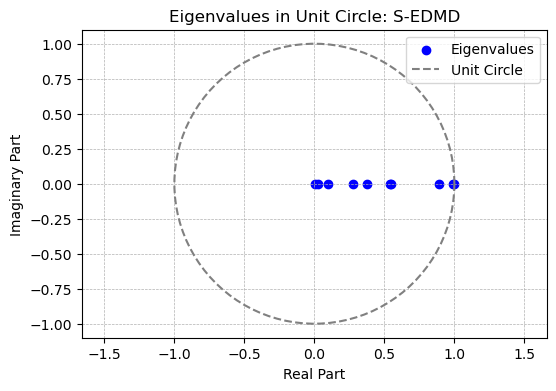

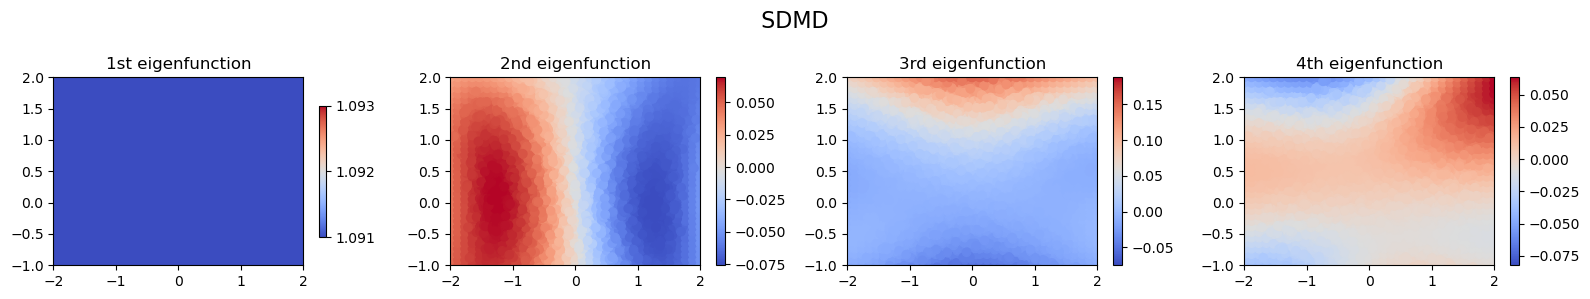

In [11]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' SDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    # 'Psi_X': Psi_X,
    # 'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9560.35iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
Outer Epoch 1/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 9466.59iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 8937.92iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 9585.59iteration/s] 


Epoch: 1 	Training Loss: 118.645782 val loss: 102.950637
saving, val loss enhanced: 102.95063687225797 1000000000000000.0
Epoch: 2 	Training Loss: 118.328190 val loss: 102.758456
saving, val loss enhanced: 102.75845632577696 102.95063687225797


/workspace/solver_gedmd_torch_gpu.py:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 3 	Training Loss: 118.011887 val loss: 102.566866
saving, val loss enhanced: 102.56686594802184 102.75845632577696
Epoch: 4 	Training Loss: 117.696088 val loss: 102.375920
saving, val loss enhanced: 102.37592036269906 102.56686594802184
Epoch 1 time: 112.20 seconds
Outer Epoch 2/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 9405.25iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9704.72iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:04<00:00, 9039.75iteration/s] 


Epoch: 1 	Training Loss: 116.973815 val loss: 102.041878
saving, val loss enhanced: 102.04187839127752 102.37592036269906
Epoch: 2 	Training Loss: 116.670097 val loss: 101.857708
saving, val loss enhanced: 101.8577081677595 102.04187839127752
Epoch: 3 	Training Loss: 116.366990 val loss: 101.673821
saving, val loss enhanced: 101.67382077445022 101.8577081677595
Epoch: 4 	Training Loss: 116.064364 val loss: 101.490299
saving, val loss enhanced: 101.49029855044809 101.67382077445022
Epoch 2 time: 113.16 seconds
Outer Epoch 3/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9889.47iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9760.97iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:04<00:00, 9028.10iteration/s]


Epoch: 1 	Training Loss: 115.350069 val loss: 101.153132
saving, val loss enhanced: 101.1531324146739 101.49029855044809
Epoch: 2 	Training Loss: 115.058781 val loss: 100.975897
saving, val loss enhanced: 100.97589746228466 101.1531324146739
Epoch: 3 	Training Loss: 114.768116 val loss: 100.798874
saving, val loss enhanced: 100.79887380711965 100.97589746228466
Epoch: 4 	Training Loss: 114.477853 val loss: 100.622111
saving, val loss enhanced: 100.62211064784091 100.79887380711965
Epoch 3 time: 116.08 seconds
Outer Epoch 4/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 10386.22iteration/s]


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9818.70iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 9308.73iteration/s]


Epoch: 1 	Training Loss: 113.806732 val loss: 100.297982
saving, val loss enhanced: 100.29798188679558 100.62211064784091
Epoch: 2 	Training Loss: 113.526927 val loss: 100.127041
saving, val loss enhanced: 100.12704117368071 100.29798188679558
Epoch: 3 	Training Loss: 113.247691 val loss: 99.956260
saving, val loss enhanced: 99.95625971027553 100.12704117368071
Epoch: 4 	Training Loss: 112.968785 val loss: 99.785669
saving, val loss enhanced: 99.78566935879284 99.95625971027553
Epoch 4 time: 101.89 seconds
Outer Epoch 5/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9634.44iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9845.84iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:03<00:00, 9195.45iteration/s]


Epoch: 1 	Training Loss: 112.344412 val loss: 99.476804
saving, val loss enhanced: 99.47680411729135 99.78566935879284
Epoch: 2 	Training Loss: 112.075215 val loss: 99.311697
saving, val loss enhanced: 99.31169703932966 99.47680411729135
Epoch: 3 	Training Loss: 111.806526 val loss: 99.146711
saving, val loss enhanced: 99.14671063568134 99.31169703932966
Epoch: 4 	Training Loss: 111.538101 val loss: 98.981866
saving, val loss enhanced: 98.98186632471622 99.14671063568134
Epoch 5 time: 106.02 seconds
Outer Epoch 6/6
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:09<00:00, 9517.19iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9705.40iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 36730/36730 [00:04<00:00, 9177.04iteration/s]


Epoch: 1 	Training Loss: 110.959939 val loss: 98.689357
saving, val loss enhanced: 98.68935673499912 98.98186632471622
Epoch: 2 	Training Loss: 110.700618 val loss: 98.529746
saving, val loss enhanced: 98.52974593939754 98.68935673499912


/workspace/solver_gedmd_torch_gpu.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


Epoch: 3 	Training Loss: 110.441745 val loss: 98.370226
saving, val loss enhanced: 98.3702255386267 98.52974593939754
Epoch: 4 	Training Loss: 110.183080 val loss: 98.210810
saving, val loss enhanced: 98.21081006169152 98.3702255386267
Epoch 6 time: 107.55 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 85740/85740 [00:08<00:00, 9798.88iteration/s] 


dPsi_X shape:  torch.Size([8574, 10])
psi_x shape:  torch.Size([8574, 10])
psi_x_inv shape:  torch.Size([10, 8574])
cuda:0
cuda:0


(10,)
[3.06534331+0.j         1.93641452+0.j         1.22244465-0.80071656j
 1.22244465+0.80071656j 1.00850197+0.j         1.        +0.j
 0.5857979 +0.j         0.5331378 -0.06140223j 0.5331378 +0.06140223j
 0.36380638+0.j        ]


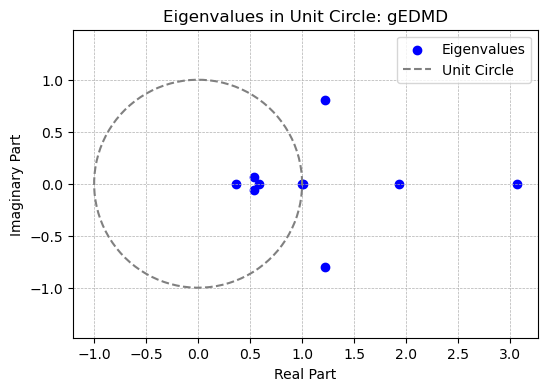

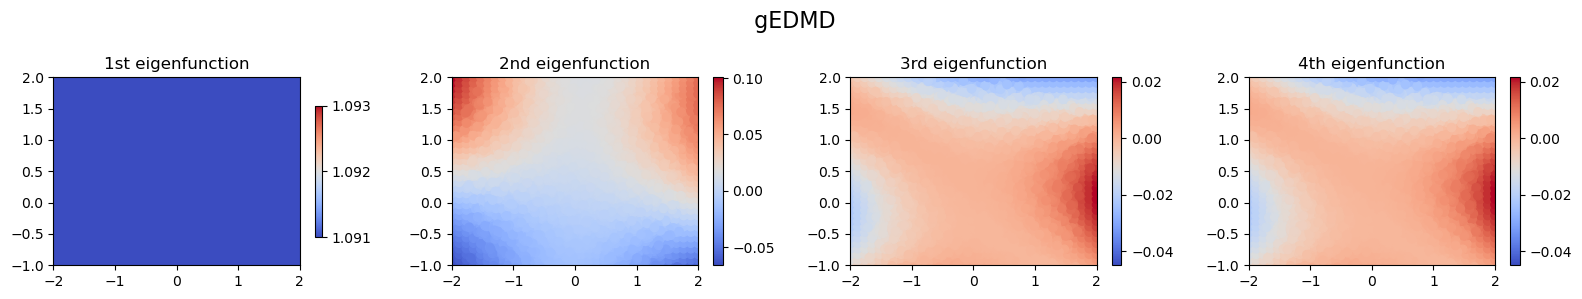

In [13]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
